In [1]:
from DipoleGroundState import MonoclinicLattice
import numpy as np
import scipy.sparse
import time
import random
import spinh 
import matplotlib.pyplot as plt

pi = np.pi
mB=9.274*10**(-24)
k=1.380*10**(-23)
NA=6.022*10**23
mu0=4*pi*10**(-7)
ErCl3 = MonoclinicLattice()
ErCl3.axes(9.57, 6.47, 7.84, 93.65*np.pi/180)
ErCl3.g_tensor(13.74, 0.75, 257*np.pi/180)
ErCl3.ion1_position(0.25, 0.1521, 0.25)
ErCl3.ion2_position(0.75, 0.8479, 0.75)

A_positions, A_labels = ErCl3.spherical_bravais_lattice(150,1,'A',1,'A')
B_positions, B_labels = ErCl3.spherical_bravais_lattice(150,1,'A',1,'B')
vertices = np.concatenate((A_positions,B_positions),axis=0)
ion_vector = ErCl3.position['1A']

factor = (mu0)/(4*pi)/((10**(-10))**3)
rx = vertices[:,0] - ion_vector[0]
ry = vertices[:,1] - ion_vector[1]
rz = vertices[:,2] - ion_vector[2]
rtot = np.sqrt(np.sum(np.power(vertices - ion_vector,2),axis=1))
mux = 0
muy = 0
muz = 0.5*mB*ErCl3.gz

Bx_each_ion = factor*((3*(muz*rz)*rx)/(rtot**5))
By_each_ion = factor*((3*(muz*rz)*ry)/(rtot**5))
Bz_each_ion = factor*(-(muz/rtot**3) + (3*(muz*rz)*rz)/(rtot**5))

def probabilty_flipped(T,Bx,By,Bz):
    boltzmann = 20.8368 #GHz/Kelvin
    p1 = np.exp(-spinh.groundsplitting(M_gnd,Bx,By,Bz)/(boltzmann*T))
    p2 = np.exp(-0)
    propability_flipping = p1/(p1+p2)
    return propability_flipping

def field(Bxs,Bys,Bzs,vertices,T,Bx_applied,By_applied,Bz_applied):    
    bias = -probabilty_flipped(T,Bx_applied,By_applied,Bz_applied)
    randoms_orientations = np.sign(np.random.rand(len(vertices))+bias)
    Bx = np.sum(Bxs*randoms_orientations) #+ Bx_applied
    By = np.sum(Bys*randoms_orientations) #+ By_applied
    Bz = np.sum(Bzs*randoms_orientations) #+ Bz_applied
    return (Bx, By, Bz)

import numpy as np
import spinh

#Applied a universal rotation to my zeeman tensors calculated from the spiral
#As a result the direction of maximam splitting is now along the z axis
#Now it's in the same coordinate frame as everything above
#Note that this hamiltonian doesn't have 
# an axial tensor, so it's not completely consistent

alpha_gnd =   0.0*np.pi/180
beta_gnd  = -90.0*np.pi/180
gamma_gnd =-167.571*np.pi/180
gx_gnd    =  13.1
gy_gnd    =   0.0
gz_gnd    =   0.55
alpha_exc =   7.924*np.pi/180
beta_exc  = -92.722*np.pi/180
gamma_exc =-168.467*np.pi/180
gx_exc    =  13.0
gy_exc    =   0.8
gz_exc    =   0.9

M_gnd = spinh.M(alpha_gnd, beta_gnd, gamma_gnd, gx_gnd, gy_gnd, gz_gnd)
M_exc = spinh.M(alpha_exc, beta_exc, gamma_exc, gx_exc, gy_exc, gz_exc)

Algorithm:
Specify some T
Set B0 for first iteration
Calculate M from given B0 and T

Caculate field at 500 lattice points using B, T and M
Calculate the average B field
Repeat using most recent B field and it's corresponding M

In [ ]:
rho = 2/(np.dot(np.cross(ErCl3.a,ErCl3.b),ErCl3.c))/((10**(-10))**3)

for T in np.linspace(0.05,1,21):
    t = time.time()
    B = [0,0,0.05]
    M = rho*np.array([mux,muy,muz])*(1-2*probabilty_flipped(T,*B))
    B_list = []
    M_list = []
    for i in range(100):
        Bcavity = mu0*M/3
        field_list = []
        for j in range(20000):
            field_list.append(field(Bx_each_ion,By_each_ion,Bz_each_ion,vertices,T,*B) + Bcavity)
        B = np.mean(field_list,axis=0)
        M = rho*np.array([mux,muy,muz])*(1-2*probabilty_flipped(T,*B))
        B_list.append(B[2])
        M_list.append(M[2])
    print(T,np.mean(B_list[-20:]),np.std(B_list[-20:]))
    plt.plot(B_list[:],label=str(T)+' K')
plt.legend()

In [3]:
sample_length = 50000
t=time.time()

distribution1 = np.empty((sample_length,3))
for i in range(sample_length):
    distribution1[i] = field(Bx_each_ion,By_each_ion,Bz_each_ion,vertices,4.2,0,0,0)
print('done distribution1')

distribution2 = np.empty((sample_length,3))
for i in range(sample_length):
    distribution2[i] = field(Bx_each_ion,By_each_ion,Bz_each_ion,vertices,0.26,0,0,0.107)
print('done distribution2') 

distribution3 = np.empty((sample_length,3))
for i in range(sample_length):
    distribution3[i] = field(Bx_each_ion,By_each_ion,Bz_each_ion,vertices,2,0,0,0.2)
print('done distribution3') 
print(time.time()-t)

done distribution1
done distribution2
139.2230577468872


I've did some field calculations at different probabilities, and discovered that when the probability of a flip is less than 0.05, the field distribution is non-gaussian. There are other distinct modes either side of the main peak.

In [14]:
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib qt
f, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.hist(distribution1[:,0]*1,50,range=(-0.2,0.2))
ax1.hist(distribution2[:,0]*1,50,range=(-0.2,0.2))
ax1.hist(distribution3[:,0]*1,50,range=(-0.2,0.2))
ax1.set_xlabel("$B_x$ at site (T)")
ax2.hist(distribution1[:,1]*1,50,range=(-0.2,0.2))
ax2.hist(distribution2[:,1]*1,50,range=(-0.2,0.2))
ax2.hist(distribution3[:,1]*1,50,range=(-0.2,0.2))
ax2.set_xlabel("$B_y$ at site (T)")
ax3.hist(distribution1[:,2]*1,50,range=(-0.2,0.2),label='4K no field')
ax3.hist(distribution2[:,2]*1,50,range=(-0.2,0.2),label='260mK 107mT')
ax3.hist(distribution3[:,2]*1,50,range=(-0.2,0.2),label='2K 200mT')
ax3.set_xlabel("$B_z$ at site (T)")

plt.legend()

plt.show()

In [ ]:
reload(spinh)
spinh.transitions_and_intensity(M_gnd,M_exc,*distribution2[1])

trans1 = np.zeros((len(distribution1),4))
intensities1 = np.zeros((len(distribution1),4))
for i in range(len(distribution1)):
    trans1[i], intensities1[i] = spinh.transitions_and_intensity(M_gnd,M_exc,*distribution1[i])
    
trans2 = np.zeros((len(distribution2),4))
intensities2 = np.zeros((len(distribution2),4))
for i in range(len(distribution2)):
    trans2[i], intensities2[i] = spinh.transitions_and_intensity(M_gnd,M_exc,*distribution2[i])

trans3 = np.zeros((len(distribution3),4))
intensities3 = np.zeros((len(distribution3),4))
for i in range(len(distribution3)):
    trans3[i], intensities3[i] = spinh.transitions_and_intensity(M_gnd,M_exc,*distribution3[i])


In [ ]:
%matplotlib qt
%matplotlib qt
%matplotlib qt
%matplotlib qt

plt.figure()
plt.hist(trans1[:,0],weights=intensities1[:,0],bins=50,range=(-5,5))
plt.hist(trans1[:,3],weights=intensities1[:,3],bins=50,range=(-5,5))
plt.hist(trans1[:,1],weights=intensities1[:,1],bins=50,range=(-5,5))
plt.hist(trans1[:,2],weights=intensities1[:,2],bins=50,range=(-5,5))
# plt.show()

prob_upper = probabilty_flipped(0.26,*distribution2[0])
prob_lower = 1-probabilty_flipped(0.26,*distribution2[0])

plt.figure()
plt.hist(trans2[:,0],weights=intensities2[:,0]*prob_lower,bins=300,range=(-30,30))
plt.hist(trans2[:,3],weights=intensities2[:,3]*prob_upper,bins=300,range=(-30,30))
plt.hist(trans2[:,1],weights=intensities2[:,1]*prob_lower,bins=300,range=(-30,30))
plt.hist(trans2[:,2],weights=intensities2[:,2]*prob_upper,bins=300,range=(-30,30))
# plt.ylim(0,100)
plt.show()

prob_upper = probabilty_flipped(2,*distribution3[0])
prob_lower = 1-probabilty_flipped(2,*distribution3[0])

plt.figure()
plt.hist(trans3[:,0],weights=intensities3[:,0]*prob_lower,bins=300,range=(-60,20))
plt.hist(trans3[:,3],weights=intensities3[:,3]*prob_upper,bins=300,range=(-60,20))
plt.hist(trans3[:,1],weights=intensities3[:,1]*prob_lower,bins=300,range=(-60,20))
plt.hist(trans3[:,2],weights=intensities3[:,2]*prob_upper,bins=300,range=(-60,20))
# plt.ylim(0,100)
plt.show()

In [ ]:
plt.plot(bincenters0,y0)
plt.xlim(-1,1)

In [ ]:
%matplotlib qt
%matplotlib qt
alpha=0.01
y0,binEdges0 = np.histogram(trans2[:,0],weights=intensities2[:,0]*prob_lower,bins=300,range=(-30,30))
y1,binEdges1 = np.histogram(trans2[:,1],weights=intensities2[:,1]*prob_lower,bins=300,range=(-30,30))
y2,binEdges2 = np.histogram(trans2[:,2],weights=intensities2[:,2]*prob_upper,bins=300,range=(-30,30))
y3,binEdges3 = np.histogram(trans2[:,3],weights=intensities2[:,3]*prob_upper,bins=300,range=(-30,30))
bincenters0 = 0.5*(binEdges0[1:]+binEdges0[:-1])
bincenters1 = 0.5*(binEdges1[1:]+binEdges1[:-1])
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
bincenters3 = 0.5*(binEdges3[1:]+binEdges3[:-1])
# plt.plot(bincenters0,np.exp(-y0*alpha),'-')
# plt.plot(bincenters1,np.exp(-y1*alpha),'-')
# plt.plot(bincenters2,np.exp(-y2*alpha),'-')
# plt.plot(bincenters3,np.exp(-y3*alpha),'-')
plt.plot(bincenters3,np.exp(-y0*alpha)*np.exp(-y1*alpha)*np.exp(-y2*alpha)*np.exp(-y3*alpha),'-')
plt.show()

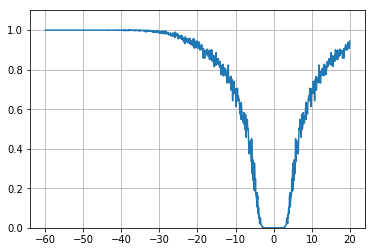

In [34]:
y0,binEdges0 = np.histogram(trans1[:,0],weights=intensities1[:,0],bins=1200,range=(-60,20))
y1,binEdges1 = np.histogram(trans1[:,3],weights=intensities1[:,3],bins=1200,range=(-60,20))
y2,binEdges2 = np.histogram(trans1[:,1],weights=intensities1[:,1],bins=1200,range=(-60,20))
y3,binEdges3 = np.histogram(trans1[:,2],weights=intensities1[:,2],bins=1200,range=(-60,20))

bincenters0 = 0.5*(binEdges0[1:]+binEdges0[:-1])
bincenters1 = 0.5*(binEdges1[1:]+binEdges1[:-1])
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
bincenters3 = 0.5*(binEdges3[1:]+binEdges3[:-1])

alpha=1
absorption0 = np.exp(-y0*alpha)
absorption1 = np.exp(-y1*alpha)
absorption2 = np.exp(-y2*alpha)
absorption3 = np.exp(-y3*alpha)

plt.plot(bincenters3,(absorption0*absorption1*absorption2*absorption3))
plt.ylim(0,1.1)
plt.grid()
# plt.xlim(-5,5)
# plt.show()

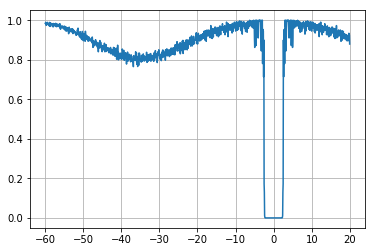

In [33]:
%matplotlib inline

plt.figure()
y0,binEdges0 = np.histogram(trans3[:,0],weights=intensities3[:,0],bins=1200,range=(-60,20))
y1,binEdges1 = np.histogram(trans3[:,3],weights=intensities3[:,3],bins=1200,range=(-60,20))
y2,binEdges2 = np.histogram(trans3[:,1],weights=intensities3[:,1],bins=1200,range=(-60,20))
y3,binEdges3 = np.histogram(trans3[:,2],weights=intensities3[:,2],bins=1200,range=(-60,20))

bincenters0 = 0.5*(binEdges0[1:]+binEdges0[:-1])
bincenters1 = 0.5*(binEdges1[1:]+binEdges1[:-1])
bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
bincenters3 = 0.5*(binEdges3[1:]+binEdges3[:-1])

alpha=1
absorption0 = np.exp(-y0*alpha)
absorption1 = np.exp(-y1*alpha)
absorption2 = np.exp(-y2*alpha)
absorption3 = np.exp(-y3*alpha)

# plt.plot(bincenters3,(absorption2))

plt.plot(bincenters3,(absorption0*absorption1*absorption2*absorption3))
# plt.ylim(0,1.1)
plt.grid()
# plt.xlim(-5,5)
plt.show()